According to Kim Yoon's paper: https://arxiv.org/abs/1408.5882, sentence classification (including sentiment analysis) can be done using CNN. This notebook I will try to take it into practice.

## Install some packages

In [1]:
import numpy as np
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import sequence
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Conv1D, GlobalMaxPool1D
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import os

Using TensorFlow backend.


## Take a sneak peek at the data
I first planned to crawl data from autohome.com but it has very strong anti-spider technique. To save time and try to evaluate if it works, I crawled around 199k comments from 58che.com to see if the CNN method works. 

In [2]:
DS_PATH = 'data/'
LABELS = {0:'neg',1:'pos'}

x = []
y = []

with open(os.path.join(DS_PATH, 'comment.txt'),'r',encoding='utf-8') as f:
    for line in f:
        row = line.split(' ', 1)
        x.append(row[1].strip())
        y.append(row[0])

y = [1 if _=='v1' else 0 for _ in y]

print('Length of data set: {}'.format(len(x)))
print('First few lines of x:')
print(x[:10])
print('First few lines of y:')
print(y[:10])

Length of data set: 189139
First few lines of x:
['不过就是起步慢一点。', '一箱油才跑400多，严重怀疑行车电脑油耗的准确性', '前中央扶手储存空间太小,只能开车垫胳膊用.', '先介绍一下我的车，骐达手动最最最最低配。月光银，4000公里以前基本油耗是5.7-5.9没有超过6.0，不过4000公里以后感觉发动机明显声音变大，油耗也有点升高达到6.0 所以近期也比较着急拉车赶紧做二保。', '我跑过180KM有点飘', '再有一个就是风声大了点', '空调坏过一次', '空调我坐后面就比较吃亏了，开到3档前面喊冷，我刚感觉到不热，比较麻烦！', '我的DD是08年6月的，现在跑了3W6。今天上班的时候挂D档起步，听到右侧前轮有轻微的“吱吱”声，下车查看无果。继续开车前进，“吱吱”声依然，踩刹车时“吱吱”声就变的很大了，松开刹车，声响随着车子前进和提速慢慢变小。再踩一脚刹车“吱吱”声又出现了。不', '车内异响。有时在波棍座附近、有时在车顶灯附近、有时在左驾驶员车窗上方...确实有时很烦人，']
First few lines of y:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Preprocessing
We will try preprocessing Chinese text in 2 ways
1. Without word split
2. With word split (like using jieba package)

In this post I will explore the method without word split.
We use keras Tokenizer to turn word(charactor) into index

In [3]:
tokenizer = Tokenizer(char_level=True, oov_token='UNK')
tokenizer.fit_on_texts(x)
DICTLEN = len(tokenizer.word_index)
print('Length of dictionary:')
print(DICTLEN)
keys = [_[0] for _ in tokenizer.word_index.items()]
values = [_[1] for _ in tokenizer.word_index.items()]
print('First few items in dictionary:')
print({k: v for k, v in zip(keys[:10],values[:10])})

Length of dictionary:
4485
First few items in dictionary:
{'，': 1, '的': 2, '。': 3, '不': 4, '车': 5, '是': 6, '有': 7, '了': 8, '0': 9, ' ': 10}


In [4]:
x_seq = tokenizer.texts_to_sequences(x)
print('First example after preprocessing:')
print(x_seq[0])

First example after preprocessing:
[4, 51, 29, 6, 79, 191, 299, 11, 32, 3]


In [5]:
x_seq[4:7]

[[22, 161, 51, 17, 92, 9, 352, 193, 7, 32, 692],
 [272, 7, 11, 27, 29, 6, 236, 83, 14, 8, 32],
 [33, 121, 621, 51, 11, 144]]

### Padding sequence
In order to train CNN easier, I make comments into same length. To do so, I use the pad_sequence function in Keras.

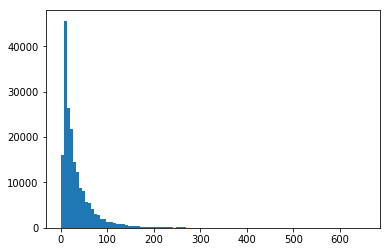

In [6]:
plt.hist(x=[len(_) for _ in x_seq], bins=100);

Let's set maxlen as 50 to be our first choice.

In [7]:
MAXLEN = 50
x_idx = sequence.pad_sequences(x_seq, maxlen=MAXLEN, padding='post', value=0)
#x_idx = x_idx.tolist()

## Split the data into train set and val set

In [8]:
np.random.seed(1)
index = list(range(len(x)))
np.random.shuffle(index)

# set training length as 95%
TRAINLEN = round(len(x)*0.95)
train_index = index[:TRAINLEN]
val_index = index[TRAINLEN:]

In [9]:
x_train_raw = [x[i] for i in train_index]
x_val_raw = [x[i] for i in val_index]

x_train = [x_idx[i] for i in train_index]
y_train = [y[i] for i in train_index]
x_val = [x_idx[i] for i in val_index]
y_val = [y[i] for i in val_index]

In [10]:
print('Positive count for whole data set:')
print('{} ({})'.format(sum(y), sum(y)/len(y)))
print('Positive count for training set:')
print('{} ({})'.format(sum(y_train), sum(y_train)/len(y_train)))
print('Positive count for validation set:')
print('{} ({})'.format(sum(y_val), sum(y_val)/len(y_val)))

Positive count for whole data set:
112515 (0.5948799560111876)
Positive count for training set:
106915 (0.5950234302823878)
Positive count for validation set:
5600 (0.5921539600296077)


In [11]:
x_train_raw[5]

'我喜欢宝马的前脸，尊贵时尚且不失霸气。'

In [19]:
x_train[5]

array([  22,  156,  228,  495,  332,    2,   73,  555,    1, 1359,  469,
         19,  244,  280,    4,  510,  637,   89,    3,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [12]:
y_train[5]

1

In [13]:
x_val_raw[1]

'油耗:让人惊喜'

In [20]:
x_val[1]

array([ 15,  54,  16, 185,  46, 391, 156,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [14]:
y_val[1]

1

### Train CNN model
Set up some basic hyper parameters first. Based on CPU or GPU:

In [15]:
if tf.test.is_gpu_available():
    BATCH_SIZE = 128
    EPOCHS = 8

else:
    BATCH_SIZE = 64
    EPOCHS = 5

In [16]:
EMBED_DIM = 40
FILTERS = 128
KERNEL_SIZE = 3
HIDDEN_UNITS = 128
VOCAB_SIZE = len(tokenizer.word_index)+1

#### 1. without drop out layer

In [17]:
model1 = Sequential()

# Start off with embedding layer to map vocab ids into EMBED_DIM dimensions
model1.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN))
#model.add(Dropout(0.2))

# Add CNN
model1.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'))

# Add Max Pooling
model1.add(GlobalMaxPool1D())

# Add an MLP
model1.add(Dense(HIDDEN_UNITS))
#model.add(Dropout(0.2))
model1.add(Activation('relu'))

# Project into single unit output layer, and convert with sigmoid
model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 40)            179440    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 128)           15488     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total para

In [18]:
model1.fit(np.array(x_train), np.array(y_train), 
          batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_split=0.1)

Train on 161713 samples, validate on 17969 samples
Epoch 1/5
161713/161713 [==============================] - 62s 384us/step - loss: 0.2738 - acc: 0.8857 - val_loss: 0.2570 - val_acc: 0.8940
Epoch 2/5
161713/161713 [==============================] - 63s 392us/step - loss: 0.2126 - acc: 0.9173 - val_loss: 0.2354 - val_acc: 0.9077
Epoch 3/5
161713/161713 [==============================] - 65s 403us/step - loss: 0.1852 - acc: 0.9286 - val_loss: 0.2306 - val_acc: 0.9096
Epoch 4/5
161713/161713 [==============================] - 63s 392us/step - loss: 0.1623 - acc: 0.9388 - val_loss: 0.2337 - val_acc: 0.9080
Epoch 5/5
161713/161713 [==============================] - 65s 399us/step - loss: 0.1423 - acc: 0.9473 - val_loss: 0.2596 - val_acc: 0.9057


As we can see epoch 3 got the lowest loss and best accuracy. For epoch > 3, the model started to overfit. 

In [21]:
score, acc = model1.evaluate(np.array(x_val), np.array(y_val), batch_size=BATCH_SIZE)
print('Accuracy:')
print(acc)

9457/9457 [==============================] - 1s 59us/step
Accuracy:
0.9069472347957659


Evaluation on validation set:

In [22]:
from sklearn.metrics import classification_report

pred = model1.predict_classes(np.array(x_val))
report = classification_report(y_pred=pred, y_true=np.array(y_val), target_names=list(LABELS.values()))
print(report)

             precision    recall  f1-score   support

        neg       0.86      0.92      0.89      3857
        pos       0.94      0.90      0.92      5600

avg / total       0.91      0.91      0.91      9457



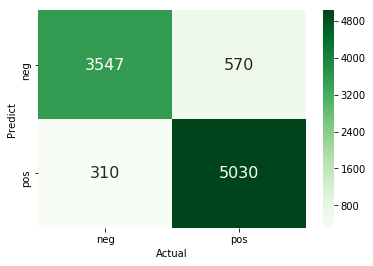

In [23]:
import pandas as pd
import seaborn as sns

predlist = [_[0] for _ in pred]
df = pd.DataFrame(data={'Predict':predlist,
                       'Actual': y_val})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

#### 2. with drop out layer

In [26]:
model2 = Sequential()

# Start off with embedding layer to map vocab ids into EMBED_DIM dimensions
model2.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN))
model2.add(Dropout(0.2))

# Add CNN
model2.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'))

# Add Max Pooling
model2.add(GlobalMaxPool1D())

# Add an MLP
model2.add(Dense(HIDDEN_UNITS))
model2.add(Dropout(0.2))
model2.add(Activation('relu'))

# Project into single unit output layer, and convert with sigmoid
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 40)            179440    
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 40)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 48, 128)           15488     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
__________

In [27]:
model2.fit(np.array(x_train), np.array(y_train), 
          batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_split=0.1)

Train on 161713 samples, validate on 17969 samples
Epoch 1/5
161713/161713 [==============================] - 71s 441us/step - loss: 0.2932 - acc: 0.8754 - val_loss: 0.2544 - val_acc: 0.8973
Epoch 2/5
161713/161713 [==============================] - 72s 444us/step - loss: 0.2356 - acc: 0.9066 - val_loss: 0.2502 - val_acc: 0.8985
Epoch 3/5
161713/161713 [==============================] - 73s 452us/step - loss: 0.2167 - acc: 0.9149 - val_loss: 0.2459 - val_acc: 0.9004
Epoch 4/5
161713/161713 [==============================] - 72s 448us/step - loss: 0.2023 - acc: 0.9211 - val_loss: 0.2327 - val_acc: 0.9078
Epoch 5/5
161713/161713 [==============================] - 72s 444us/step - loss: 0.1926 - acc: 0.9258 - val_loss: 0.2321 - val_acc: 0.9080


From above it seems like we can set EPOCHS larger because val_loss is still decreasing.

In [28]:
score, acc = model2.evaluate(np.array(x_val), np.array(y_val), batch_size=BATCH_SIZE)
print('Accuracy:')
print(acc)

9457/9457 [==============================] - 1s 73us/step
Accuracy:
0.9126572910468977


Evaluation on validation set:

In [29]:
from sklearn.metrics import classification_report

pred = model2.predict_classes(np.array(x_val))
report = classification_report(y_pred=pred, y_true=np.array(y_val), target_names=list(LABELS.values()))
print(report)

             precision    recall  f1-score   support

        neg       0.88      0.91      0.89      3857
        pos       0.94      0.91      0.93      5600

avg / total       0.91      0.91      0.91      9457



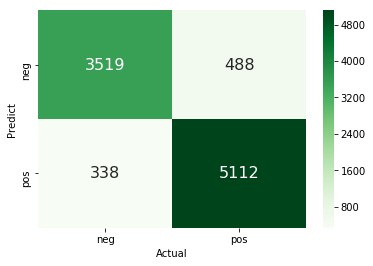

In [30]:
import pandas as pd
import seaborn as sns

predlist = [_[0] for _ in pred]
df = pd.DataFrame(data={'Predict':predlist,
                       'Actual': y_val})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

#### 3. Changing filter kernal size from 3 to 5

In [31]:
KERNEL_SIZE = 5

In [32]:
model3 = Sequential()

# Start off with embedding layer to map vocab ids into EMBED_DIM dimensions
model3.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN))
model3.add(Dropout(0.2))

# Add CNN
model3.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'))

# Add Max Pooling
model3.add(GlobalMaxPool1D())

# Add an MLP
model3.add(Dense(HIDDEN_UNITS))
model3.add(Dropout(0.2))
model3.add(Activation('relu'))

# Project into single unit output layer, and convert with sigmoid
model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 40)            179440    
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 40)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 46, 128)           25728     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
__________

In [33]:
model3.fit(np.array(x_train), np.array(y_train), 
          batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_split=0.1)

Train on 161713 samples, validate on 17969 samples
Epoch 1/5
161713/161713 [==============================] - 76s 473us/step - loss: 0.2876 - acc: 0.8793 - val_loss: 0.2502 - val_acc: 0.9003
Epoch 2/5
161713/161713 [==============================] - 78s 484us/step - loss: 0.2290 - acc: 0.9092 - val_loss: 0.2436 - val_acc: 0.9016
Epoch 3/5
161713/161713 [==============================] - 78s 480us/step - loss: 0.2082 - acc: 0.9187 - val_loss: 0.2358 - val_acc: 0.9082
Epoch 4/5
161713/161713 [==============================] - 79s 486us/step - loss: 0.1940 - acc: 0.9248 - val_loss: 0.2356 - val_acc: 0.9091
Epoch 5/5
161713/161713 [==============================] - 79s 489us/step - loss: 0.1844 - acc: 0.9289 - val_loss: 0.2321 - val_acc: 0.9084


In [34]:
score, acc = model3.evaluate(np.array(x_val), np.array(y_val), batch_size=BATCH_SIZE)
print('Accuracy:')
print(acc)

9457/9457 [==============================] - 1s 78us/step
Accuracy:
0.9166754786328128


In [35]:
from sklearn.metrics import classification_report

pred = model3.predict_classes(np.array(x_val))
report = classification_report(y_pred=pred, y_true=np.array(y_val), target_names=list(LABELS.values()))
print(report)

             precision    recall  f1-score   support

        neg       0.90      0.90      0.90      3857
        pos       0.93      0.93      0.93      5600

avg / total       0.92      0.92      0.92      9457



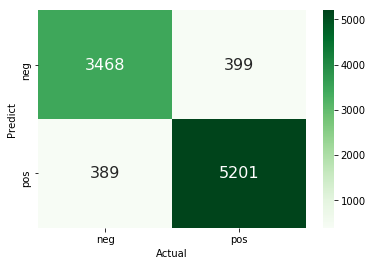

In [36]:
import pandas as pd
import seaborn as sns

predlist = [_[0] for _ in pred]
df = pd.DataFrame(data={'Predict':predlist,
                       'Actual': y_val})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

### Check error
We choose the best performing model and look at the wrong predictions and dig out what to do next.
#### 1. positive comment

In [44]:
best_model = model3
pred = best_model.predict_classes(np.array(x_val))
predlist = [_[0] for _ in pred]
df = pd.DataFrame(data={'Predict':predlist,
                       'Actual': y_val})
error_index = df[df['Predict']!=df['Actual']].index

In [58]:
print(x_val_raw[error_index[0]],y_val[error_index[0]],predlist[error_index[0]])

下次便宜点 0 1


In [60]:
print(x_val_raw[error_index[1]],y_val[error_index[1]],predlist[error_index[1]])

永远不知足，就是没有5，7的。3，6的还不错，在城市使用已经足够了，超车什么的很利落，想撒撒野就不够了。 0 1


In [61]:
print(x_val_raw[error_index[2]],y_val[error_index[2]],predlist[error_index[2]])

操控:刹车一般 1 0


In [62]:
print(x_val_raw[error_index[3]],y_val[error_index[3]],predlist[error_index[3]])

动力:拖拉机 0 1


In [63]:
print(x_val_raw[error_index[4]],y_val[error_index[4]],predlist[error_index[4]])

多功能仪表板太小，1/3是空着没用的，哪怕只显示时间也行啊！老款的仪表显示要方便多了，再次鄙视SVW优点就不说了，省的说自卖自夸。 0 1
